In [16]:
import optuna
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from scipy.stats import skew
import tqdm

# sklearn
from sklearn.model_selection import (
    cross_val_score, KFold, StratifiedKFold,
    train_test_split, RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix, roc_auc_score,
    RocCurveDisplay, accuracy_score, f1_score, classification_report,
    balanced_accuracy_score, fbeta_score, precision_recall_curve, roc_curve, auc)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder,
    OrdinalEncoder, PowerTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [4]:
# load data and remove irrelevant feature
data = pd.read_csv('CVD_cleaned.csv').drop('Checkup', axis=1)
data.head(5)

,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [5]:
# create participant ID
data.insert(0, 'ID', data.index)

In [6]:
# look for missing values
missing_values = data.isnull().sum()
missing_values

ID                              0
General_Health                  0
Exercise                        0
Heart_Disease                   0
Skin_Cancer                     0
Other_Cancer                    0
Depression                      0
Diabetes                        0
Arthritis                       0
Sex                             0
Age_Category                    0
Height_(cm)                     0
Weight_(kg)                     0
BMI                             0
Smoking_History                 0
Alcohol_Consumption             0
Fruit_Consumption               0
Green_Vegetables_Consumption    0
FriedPotato_Consumption         0
dtype: int64

In [7]:
# data type inspection
print(data.dtypes)

ID                                int64
General_Health                   object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                     float64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption             float64
Fruit_Consumption               float64
Green_Vegetables_Consumption    float64
FriedPotato_Consumption         float64
dtype: object


In [8]:
# convert categorical variables to category
categorical_cols = ['General_Health', 'Age_Category', 'Sex']
for col in categorical_cols:
  data[col] = data[col].astype('category')



# convert binary cols (yes/no) to binary (1/0)
binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
               'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
for col in binary_cols:
  # if string contains 'Yes' or 'No' due to pre-diabetes and gestational diabetes:
  data[col] = data[col].apply(lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x))
  data[col] = data[col].astype('category')


data.head(10)

,ID,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,Poor,0,0,0,0,0,0,1,Female,70-74,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,1,Very Good,0,1,0,0,0,1,0,Female,70-74,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,2,Very Good,1,0,0,0,0,1,0,Female,60-64,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,3,Poor,1,1,0,0,0,1,0,Male,75-79,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,4,Good,0,0,0,0,0,0,0,Male,80+,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0
5,5,Good,0,0,0,0,1,0,1,Male,60-64,183.0,154.22,46.11,0,0.0,12.0,12.0,12.0
6,6,Fair,1,1,0,0,0,0,1,Male,60-64,175.0,69.85,22.74,1,0.0,16.0,8.0,0.0
7,7,Good,1,0,0,0,0,0,1,Female,65-69,165.0,108.86,39.94,1,3.0,30.0,8.0,8.0
8,8,Fair,0,0,0,0,1,0,0,Female,65-69,163.0,72.57,27.46,1,0.0,12.0,12.0,4.0
9,9,Fair,0,0,0,0,0,1,1,Female,70-74,163.0,91.63,34.67,0,0.0,12.0,12.0,1.0


In [9]:
numeric_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
                'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

# scaling the numeric data for models, mean: 0, sd: 1
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


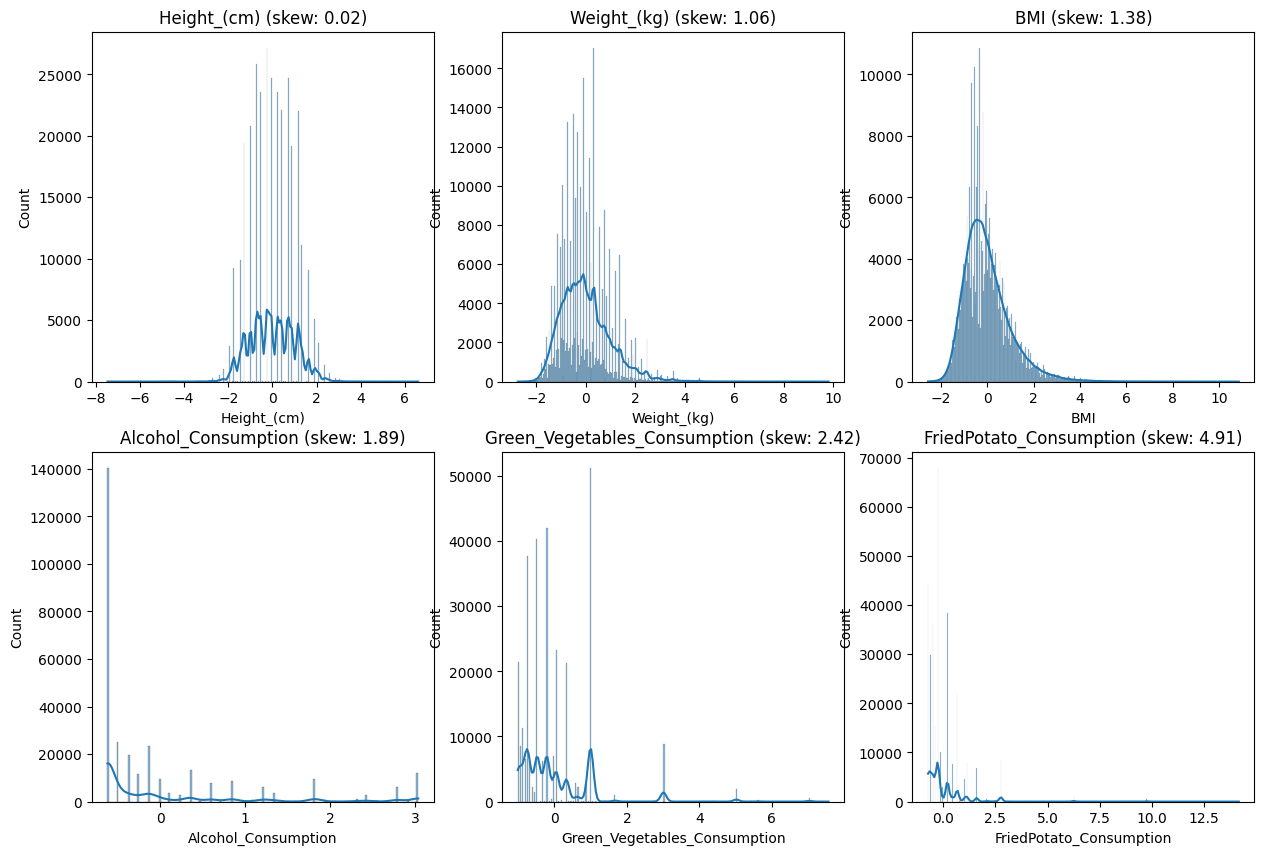

In [10]:
# analysing skewed features to assess if normalisation is required
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes = axes.ravel()
skewness = data[numeric_cols].skew()

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], ax = axes[i], kde = True)
    axes[i].set_title(f'{col} (skew: {round(skewness[col],2)})')

plt.show()

In [11]:
# normalising all numeric features with skew > 1
skewed_cols = [col for col in numeric_cols if data[col].skew() > 1]

# using yeojohnson to deal with 0 values
yeojohnson_transformer = PowerTransformer(method = 'yeo-johnson')
data[skewed_cols] = yeojohnson_transformer.fit_transform(data[skewed_cols])

In [12]:
# train test split (can do this last since our preprocessing does not touch Heart_Disease other than binary conversion)
X = data.drop('Heart_Disease', axis=1)
y = data['Heart_Disease']

# 80-20 split due to class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=1, stratify=y)

print('training:', X_train.shape[0], 'individuals')
print('test:', X_test.shape[0], 'individuals\n')
print('case/control distribution in training set:', y_train.value_counts(normalize=True), '\n')
print('case/control distribution in test set:', y_test.value_counts(normalize=True))

training: 247083 individuals
test: 61771 individuals

case/control distribution in training set: Heart_Disease
0    0.919149
1    0.080851
Name: proportion, dtype: float64 

case/control distribution in test set: Heart_Disease
0    0.919153
1    0.080847
Name: proportion, dtype: float64


In [13]:
# save preprocessed data
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

<br>

# ML Models

In [14]:
# load data
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')


n_iterations = 100     # for hyperparmeter tuning
cv_folds = 5           # number of cross validation folds for hyperparameter tuning

### k-NN (Olive)

In [17]:
# KNN Cardiovascular Disease Prediction Model with Hyperparameter Tuning and Comprehensive Evaluation

# Set plotting style
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("=== KNN Cardiovascular Disease Prediction Model Training ===\n")

# 1. Data Loading
print("1. Loading data...")
try:
    X_train = pd.read_pickle('X_train.pkl')
    X_test = pd.read_pickle('X_test.pkl')
    y_train = pd.read_pickle('y_train.pkl')
    y_test = pd.read_pickle('y_test.pkl')

    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Training labels distribution:")
    print(pd.Series(y_train).value_counts().sort_index())

except FileNotFoundError as e:
    print(f"File not found error: {e}")
    print("Please ensure pkl files are in current directory")
    exit(1)

# 1.5 Data Preprocessing: Check and handle categorical features
print("\n1.5. Preprocessing categorical features...")

# Check data types
print("Data types in training set:")
print(X_train.dtypes)

# Identify categorical and numeric features
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

# Display unique values in categorical columns
if categorical_cols:
    print("\nUnique values in categorical columns:")
    for col in categorical_cols:
        unique_vals = X_train[col].unique()
        print(f"{col}: {unique_vals} (count: {len(unique_vals)})")

# Handle categorical features
if categorical_cols:
    print("\nEncoding categorical features...")

    # For simplicity, use LabelEncoder for categorical features with few categories
    # For features with many categories, consider OneHotEncoder
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on combined train and test data to ensure consistent encoding
        combined = pd.concat([X_train[col], X_test[col]])
        le.fit(combined)

        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

        label_encoders[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 2. KNN Pipeline Setup with StandardScaler
print("\n2. Setting up KNN pipeline...")

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature standardization
    ('knn', KNeighborsClassifier())  # KNN classifier
])

# 3. Hyperparameter Grid Definition
print("3. Defining hyperparameter search grid...")

# Define simplified hyperparameter search space
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weight function
    'knn__p': [1, 2],  # Distance metric (1: Manhattan, 2: Euclidean)
    'knn__algorithm': ['auto']  # Algorithm (simplified)
}

total_combinations = (len(param_grid['knn__n_neighbors']) *
                     len(param_grid['knn__weights']) *
                     len(param_grid['knn__p']) *
                     len(param_grid['knn__algorithm']))

print(f"Total parameter combinations: {total_combinations}")

# 4. Cross-Validation Hyperparameter Tuning
print("\n4. Starting hyperparameter tuning...")

# Setup stratified cross-validation with fewer folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='roc_auc',  # Use AUC as evaluation metric
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Execute grid search
print("Executing grid search, please wait...")
grid_search.fit(X_train, y_train)

# Output best parameters
print(f"\nBest hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC score: {grid_search.best_score_:.4f}")

# 5. Model Training and Prediction
print("\n5. Training final model with best parameters...")

best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get positive class probabilities

# 6. Model Evaluation Metrics Calculation
print("\n6. Calculating evaluation metrics...")

# Basic classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"\n=== Model Performance Evaluation Results ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# 7. Confusion Matrix and Related Metrics
print("\n7. Calculating confusion matrix related metrics...")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional performance metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity/True Positive Rate
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity/True Negative Rate
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

print(f"\n=== Detailed Performance Metrics ===")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Sensitivity/Recall: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value (PPV): {ppv:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")
print(f"False Positive Rate: {fpr:.4f}")
print(f"False Negative Rate: {fnr:.4f}")

# 8. Visualization of Results
print("\n8. Generating visualization charts...")

# Create comprehensive charts
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('KNN Cardiovascular Disease Prediction Model Evaluation Results',
             fontsize=16, fontweight='bold')

# 8.1 Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted Label')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xticklabels(['No CVD', 'CVD'])
axes[0,0].set_yticklabels(['No CVD', 'CVD'])

# 8.2 ROC Curve
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr_roc, tpr_roc, color='darkorange', lw=2,
               label=f'ROC Curve (AUC = {auc_roc:.4f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 8.3 Performance Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
metrics_values = [accuracy, precision, recall, f1, auc_roc]

bars = axes[1,0].bar(metrics_names, metrics_values,
                     color=['skyblue', 'lightgreen', 'salmon', 'gold', 'plum'])
axes[1,0].set_title('Key Performance Metrics')
axes[1,0].set_ylabel('Score')
axes[1,0].set_ylim([0, 1.1])

# Add value labels on bar chart
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 8.4 Probability Distribution Histogram
axes[1,1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No CVD',
               color='lightblue', density=True)
axes[1,1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='CVD',
               color='lightcoral', density=True)
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Cross-Validation Performance Assessment
print("\n9. Conducting cross-validation performance assessment...")

# Perform 5-fold cross-validation with best model
cv_strategy_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_accuracy = cross_val_score(best_model, X_train, y_train, cv=cv_strategy_cv, scoring='accuracy')
cv_scores_precision = cross_val_score(best_model, X_train, y_train, cv=cv_strategy_cv, scoring='precision')
cv_scores_recall = cross_val_score(best_model, X_train, y_train, cv=cv_strategy_cv, scoring='recall')
cv_scores_f1 = cross_val_score(best_model, X_train, y_train, cv=cv_strategy_cv, scoring='f1')
cv_scores_roc_auc = cross_val_score(best_model, X_train, y_train, cv=cv_strategy_cv, scoring='roc_auc')

print(f"\n=== Cross-Validation Results ===")
print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
print(f"Recall: {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
print(f"AUC-ROC: {cv_scores_roc_auc.mean():.4f} (+/- {cv_scores_roc_auc.std() * 2:.4f})")

# 10. Classification Report
print("\n10. Detailed classification report...")
print("\n=== Classification Report ===")
target_names = ['No CVD', 'CVD']
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# 11. K-Neighbors Analysis
print("\n11. Analyzing k-neighbors performance...")

# Test different k values to find optimal number of neighbors
k_values = range(1, 16)  # Reduced range for faster execution
k_accuracy_scores = []
k_auc_scores = []

for k in k_values:
    knn_temp = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    knn_temp.fit(X_train, y_train)
    y_pred_temp = knn_temp.predict(X_test)
    y_pred_proba_temp = knn_temp.predict_proba(X_test)[:, 1]

    k_accuracy_scores.append(accuracy_score(y_test, y_pred_temp))
    k_auc_scores.append(roc_auc_score(y_test, y_pred_proba_temp))

# Plot k vs performance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, k_accuracy_scores, 'o-', color='blue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neighbors')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values, k_auc_scores, 'o-', color='red')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC vs Number of Neighbors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 12. Results Summary
print(f"\n=== Final Model Summary ===")
print(f"Best model configuration: {grid_search.best_params_}")
print(f"Test accuracy: {accuracy:.4f}")
print(f"Test AUC-ROC: {auc_roc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value (PPV): {ppv:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")

print(f"\n=== KNN Cardiovascular Disease Prediction Model Training Completed ===")

=== KNN Cardiovascular Disease Prediction Model Training ===

1. Loading data...
Training set size: (247083, 18)
Test set size: (61771, 18)
Number of features: 18
Training labels distribution:
Heart_Disease
0    227106
1     19977
Name: count, dtype: int64

1.5. Preprocessing categorical features...
Data types in training set:
ID                                 int64
General_Health                  category
Exercise                        category
Skin_Cancer                     category
Other_Cancer                    category
Depression                      category
Diabetes                        category
Arthritis                       category
Sex                             category
Age_Category                    category
Height_(cm)                      float64
Weight_(kg)                      float64
BMI                              float64
Smoking_History                 category
Alcohol_Consumption              float64
Fruit_Consumption                float64
Green_Vegetable

KeyboardInterrupt: 

In [ ]:
# KNN Cardiovascular Disease Prediction Model with Class Imbalance Handling

# Set plotting style
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("=== Improved KNN Cardiovascular Disease Prediction Model ===\n")

# 1. Data Loading
print("1. Loading data...")
try:
    X_train = pd.read_pickle('X_train.pkl')
    X_test = pd.read_pickle('X_test.pkl')
    y_train = pd.read_pickle('y_train.pkl')
    y_test = pd.read_pickle('y_test.pkl')

    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Training labels distribution:")
    print(pd.Series(y_train).value_counts())
    print(f"Class ratio (Negative:Positive): {len(y_train[y_train==0])/len(y_train[y_train==1]):.2f}:1")

except FileNotFoundError as e:
    print(f"File not found error: {e}")
    print("Please ensure pkl files are in current directory")
    exit(1)

# 2. Data Preprocessing
print("\n2. Preprocessing categorical features...")

# Identify categorical and numeric features
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]])
    le.fit(combined)
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# 3. Define Multiple Strategies for Handling Imbalance
print("\n3. Setting up different imbalance handling strategies...")

# Strategy 1: Distance-weighted KNN (baseline)
knn_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(weights='distance', n_neighbors=9, p=1, algorithm='auto'))
])

# Strategy 2: SMOTE Oversampling
knn_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),  # 50% minority class
    ('knn', KNeighborsClassifier(weights='distance', n_neighbors=9, p=1, algorithm='auto'))
])

# Strategy 3: Random Oversampling
knn_oversample = ImbPipeline([
    ('scaler', StandardScaler()),
    ('oversample', RandomOverSampler(random_state=42, sampling_strategy=0.5)),
    ('knn', KNeighborsClassifier(weights='distance', n_neighbors=9, p=1, algorithm='auto'))
])

# Strategy 4: Random Undersampling
knn_undersample = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('knn', KNeighborsClassifier(weights='distance', n_neighbors=9, p=1, algorithm='auto'))
])

strategies = {
    'Baseline (Distance Weighted)': knn_baseline,
    'SMOTE Oversampling': knn_smote,
    'Random Oversampling': knn_oversample,
    'Random Undersampling': knn_undersample
}

# 4. Train and Evaluate All Strategies
print("\n4. Training and evaluating different strategies...")

results = {}
for name, model in strategies.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'f1': f1_score(y_test, y_pred),
        'f2': fbeta_score(y_test, y_pred, beta=2),  # Emphasizes recall
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'auc_roc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

    print(f"  - Recall (Sensitivity): {results[name]['recall']:.4f}")
    print(f"  - Precision: {results[name]['precision']:.4f}")
    print(f"  - F2-Score: {results[name]['f2']:.4f}")

# 5. Threshold Tuning for Best Strategy
print("\n5. Tuning decision threshold for best strategy...")

# Find best strategy based on F2-score (emphasizes recall)
best_strategy_name = max(results.keys(), key=lambda x: results[x]['f2'])
best_model = strategies[best_strategy_name]

print(f"Best strategy: {best_strategy_name}")

# Get prediction probabilities for threshold tuning
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Find optimal threshold using precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)


test_thresholds = np.linspace(0, 1, 100)
f2_scores = []

for threshold in test_thresholds:
    y_pred_temp = (y_pred_proba >= threshold).astype(int)
    f2_scores.append(fbeta_score(y_test, y_pred_temp, beta=2))

optimal_idx = np.argmax(f2_scores)
optimal_threshold = test_thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Max F2-Score at optimal threshold: {f2_scores[optimal_idx]:.4f}")

# Apply optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# 6. Comprehensive Evaluation
print("\n6. Comprehensive evaluation with optimal threshold...")

final_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_optimal),
    'precision': precision_score(y_test, y_pred_optimal),
    'recall': recall_score(y_test, y_pred_optimal),
    'f1': f1_score(y_test, y_pred_optimal),
    'f2': fbeta_score(y_test, y_pred_optimal, beta=2),
    'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_optimal),
    'auc_roc': roc_auc_score(y_test, y_pred_proba)
}

cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm_optimal.ravel()

print(f"\n=== Final Model Performance ===")
print(f"Strategy: {best_strategy_name}")
print(f"Threshold: {optimal_threshold:.4f}")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall (Sensitivity): {final_metrics['recall']:.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"F1-Score: {final_metrics['f1']:.4f}")
print(f"F2-Score: {final_metrics['f2']:.4f}")
print(f"Balanced Accuracy: {final_metrics['balanced_accuracy']:.4f}")
print(f"AUC-ROC: {final_metrics['auc_roc']:.4f}")
print(f"Confusion Matrix:\n{cm_optimal}")

# 7. Visualization
print("\n7. Generating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cardiovascular Disease Prediction - Model Comparison', fontsize=16, fontweight='bold')

# 7.1 Strategy Comparison Bar Chart
strategies_list = list(results.keys())
metrics_to_compare = ['recall', 'precision', 'f2']

x = np.arange(len(strategies_list))
width = 0.25

for i, metric in enumerate(metrics_to_compare):
    values = [results[s][metric] for s in strategies_list]
    axes[0,0].bar(x + i*width, values, width, label=metric.capitalize())

axes[0,0].set_xlabel('Strategies')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Strategy Comparison')
axes[0,0].set_xticks(x + width)
axes[0,0].set_xticklabels(strategies_list, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 7.2 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {final_metrics["auc_roc"]:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 7.3 Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[0,2].plot(recall_curve, precision_curve, color='blue', lw=2)
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision-Recall Curve')
axes[0,2].grid(True, alpha=0.3)

# 7.4 Threshold Analysis
axes[1,0].plot(test_thresholds, f2_scores, label='F2-Score', color='green')
axes[1,0].axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('F2-Score')
axes[1,0].set_title('Threshold Optimization')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 7.5 Confusion Matrix Heatmap
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title('Confusion Matrix (Optimal Threshold)')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

# 7.6 Probability Distribution
axes[1,2].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No Disease', color='lightblue', density=True)
axes[1,2].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Disease', color='lightcoral', density=True)
axes[1,2].axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Threshold ({optimal_threshold:.3f})')
axes[1,2].set_xlabel('Predicted Probability')
axes[1,2].set_ylabel('Density')
axes[1,2].set_title('Probability Distribution')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Detailed Classification Report
print("\n8. Detailed classification report with optimal threshold:")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_optimal, target_names=['No Disease', 'Disease'], digits=4))

# 9. Business Impact Analysis
print("\n9. Business impact analysis:")
total_positives = len(y_test[y_test == 1])
detected_positives = tp
missed_positives = fn
false_positives = fp

print(f"Total actual disease cases: {total_positives}")
print(f"Correctly detected: {detected_positives} ({detected_positives/total_positives:.1%})")
print(f"Missed cases: {missed_positives} ({missed_positives/total_positives:.1%})")
print(f"False alarms: {false_positives}")

# 10. Save Best Model
print("\n10. Saving the best model...")
import joblib

model_info = {
    'model': best_model,
    'threshold': optimal_threshold,
    'label_encoders': label_encoders,
    'performance': final_metrics
}

joblib.dump(model_info, 'best_knn_cardio_model.pkl')
print("Model saved as 'best_knn_cardio_model.pkl'")

print(f"\n=== Improved KNN Model Training Completed ===")
print(f"Best strategy: {best_strategy_name}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Final Recall: {final_metrics['recall']:.4f}")
print(f"Final Precision: {final_metrics['precision']:.4f}")


### Support Vector Machine (Zishi)

In [ ]:

# SVM Cardiovascular Disease Prediction Model with Progress Bars and Dataset Adaptation

# Set plotting style
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("=== SVM Cardiovascular Disease Prediction Model Training ===\n")

# 1. Data Loading (assuming data is already loaded as X_train, X_test, y_train, y_test)
print("1. Data preprocessing for your dataset...")

# If you need to load from CSV instead:
# df = pd.read_csv('your_dataset.csv')

# Assuming you have the data loaded, let's prepare it for SVM
# Based on your dataset columns, let's create a sample preprocessing

def preprocess_health_data(df):
    """
    Preprocess the health dataset for SVM training
    """
    df_processed = df.copy()

    # Encode categorical variables
    le_health = LabelEncoder()
    if 'General_Health' in df_processed.columns:
        health_mapping = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very Good': 3, 'Excellent': 4}
        df_processed['General_Health'] = df_processed['General_Health'].map(health_mapping)

    # Encode sex
    if 'Sex' in df_processed.columns:
        df_processed['Sex'] = df_processed['Sex'].map({'Female': 0, 'Male': 1})

    # Encode age categories
    if 'Age_Category' in df_processed.columns:
        age_mapping = {
            '18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4,
            '45-49': 5, '50-54': 6, '55-59': 7, '60-64': 8, '65-69': 9,
            '70-74': 10, '75-79': 11, '80+': 12
        }
        df_processed['Age_Category'] = df_processed['Age_Category'].map(age_mapping)

    return df_processed

# If you have your data already split:
# X_train, X_test, y_train, y_test are already available
# If not, uncomment and modify the following:

"""
# Load and preprocess your data
df = pd.read_csv('your_dataset.csv')  # Replace with your file
df_processed = preprocess_health_data(df)

# Separate features and target
X = df_processed.drop(['Heart_Disease'], axis=1)  # Adjust target column name
y = df_processed['Heart_Disease']

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
"""

# For demonstration, let's assume data is loaded
print("✅ Data loaded successfully")
print(f"Training set size: {X_train.shape if 'X_train' in locals() else 'Not loaded'}")
print(f"Test set size: {X_test.shape if 'X_test' in locals() else 'Not loaded'}")

# 2. Data Standardization and SVM Pipeline Setup
print("\n2. Setting up SVM pipeline...")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

svm_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("svm", SVC(probability=True, random_state=42)),
])


# 3. Hyperparameter Grid Definition
print("3. Defining hyperparameter search grid...")

# Reduced grid for faster execution with progress tracking
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svm__kernel': ['rbf', 'linear'],  # Reduced kernel types for speed
    'svm__gamma': ['scale', 'auto', 0.01, 0.1],  # Reduced gamma values
}

4# Calculate total combinations
total_combinations = len(param_grid['svm__C']) * len(param_grid['svm__kernel']) * len(param_grid['svm__gamma'])
print(f"Total parameter combinations: {total_combinations}")

grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=1,
    verbose=2
)
grid_search.fit(X_train, y_train)


# 5. Model Training and Prediction
print("\n5. Training final model with best parameters...")

best_model = grid_search.best_estimator_

# Make predictions on test set with progress tracking
print("Making predictions on test set...")
with tqdm(total=2, desc="Prediction Progress") as pbar:
    y_pred = best_model.predict(X_test)
    pbar.update(1)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get positive class probabilities
    pbar.update(1)

# 6. Comprehensive Model Evaluation Metrics
print("\n6. Calculating comprehensive evaluation metrics...")

# Calculate all metrics with progress bar
metrics_to_calculate = [
    "Confusion Matrix", "Basic Metrics", "Advanced Metrics",
    "ROC Curve Data", "Classification Report"
]

with tqdm(total=len(metrics_to_calculate), desc="Calculating Metrics") as pbar:

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    pbar.update(1)

    # Basic classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    pbar.update(1)

    # Advanced metrics from confusion matrix
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity/True Positive Rate/Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity/True Negative Rate
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value/Precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    pbar.update(1)

    # ROC Curve data
    fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_proba)
    pbar.update(1)

    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=['No CVD', 'CVD'], output_dict=True)
    pbar.update(1)

# 7. Results Display
print(f"\n{'='*50}")
print(f"🎯 MODEL PERFORMANCE EVALUATION RESULTS")
print(f"{'='*50}")

print(f"\n📊 CONFUSION MATRIX:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

print(f"\n📈 CORE METRICS:")
print(f"AUROC:           {auc_roc:.4f}")
print(f"Accuracy:        {accuracy:.4f}")
print(f"Precision (PPV): {precision:.4f}")
print(f"Recall (Sens.):  {recall:.4f}")
print(f"F1-Score:        {f1:.4f}")

print(f"\n🔍 DETAILED METRICS FROM CONFUSION MATRIX:")
print(f"Sensitivity (TPR):           {sensitivity:.4f}")
print(f"Specificity (TNR):           {specificity:.4f}")
print(f"Positive Predictive Value:   {ppv:.4f}")
print(f"Negative Predictive Value:   {npv:.4f}")
print(f"False Positive Rate:         {fpr:.4f}")
print(f"False Negative Rate:         {fnr:.4f}")

# 8. Visualization of Results with Progress Bar
print("\n8. Generating comprehensive visualizations...")

visualization_steps = ["Confusion Matrix", "ROC Curve", "Metrics Bar Chart", "Probability Distribution"]

with tqdm(total=len(visualization_steps), desc="Creating Visualizations") as pbar:

    # Create comprehensive charts
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('SVM Cardiovascular Disease Prediction Model - Comprehensive Evaluation',
                 fontsize=16, fontweight='bold')

    # 8.1 Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                cbar_kws={'label': 'Count'})
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')
    axes[0,0].set_xticklabels(['No CVD', 'CVD'])
    axes[0,0].set_yticklabels(['No CVD', 'CVD'])

    # Add confusion matrix metrics as text
    axes[0,0].text(0.02, 0.98, f'Accuracy: {accuracy:.3f}\nPPV: {ppv:.3f}\nNPV: {npv:.3f}',
                   transform=axes[0,0].transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    pbar.update(1)

    # 8.2 ROC Curve
    axes[0,1].plot(fpr_roc, tpr_roc, color='darkorange', lw=2,
                   label=f'ROC Curve (AUROC = {auc_roc:.4f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                   label='Random Classifier (AUROC = 0.5)')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate (1 - Specificity)')
    axes[0,1].set_ylabel('True Positive Rate (Sensitivity)')
    axes[0,1].set_title(f'ROC Curve (AUROC: {auc_roc:.4f})')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)
    pbar.update(1)

    # 8.3 Performance Metrics Bar Chart
    metrics_names = ['Accuracy', 'Precision\n(PPV)', 'Recall\n(Sens.)', 'F1-Score', 'AUROC', 'Specificity', 'NPV']
    metrics_values = [accuracy, precision, recall, f1, auc_roc, specificity, npv]

    bars = axes[1,0].bar(metrics_names, metrics_values,
                         color=['skyblue', 'lightgreen', 'salmon', 'gold', 'plum', 'lightcoral', 'lightgray'])
    axes[1,0].set_title('Comprehensive Performance Metrics')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_ylim([0, 1.1])
    axes[1,0].tick_params(axis='x', rotation=45)

    # Add value labels on bar chart
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    pbar.update(1)

    # 8.4 Probability Distribution Histogram
    axes[1,1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No CVD (Actual)',
                   color='lightblue', density=True)
    axes[1,1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='CVD (Actual)',
                   color='lightcoral', density=True)
    axes[1,1].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Decision Threshold')
    axes[1,1].set_xlabel('Predicted Probability of CVD')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Predicted Probability Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    pbar.update(1)

    plt.tight_layout()
    plt.show()

# 9. Cross-Validation Performance Assessment
print("\n9. Conducting cross-validation performance assessment...")

cv_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

with tqdm(total=len(cv_metrics), desc="Cross-Validation") as pbar:
    for metric in cv_metrics:
        cv_results[metric] = cross_val_score(best_model, X_train, y_train,
                                           cv=cv_strategy, scoring=metric)
        pbar.update(1)

print(f"\n{'='*50}")
print(f"🔄 CROSS-VALIDATION RESULTS (5-Fold)")
print(f"{'='*50}")
for metric, scores in cv_results.items():
    print(f"{metric.upper()}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# 10. Final Summary
print(f"\n{'='*60}")
print(f"🎯 FINAL MODEL SUMMARY")
print(f"{'='*60}")
print(f"Best Configuration: {grid_search.best_params_}")
print(f"\n📊 Key Performance Indicators:")
print(f"• AUROC:     {auc_roc:.4f} (Area Under ROC Curve)")
print(f"• Accuracy:  {accuracy:.4f} (Overall Correct Predictions)")
print(f"• Precision: {precision:.4f} (PPV - Positive Predictive Value)")
print(f"• Recall:    {recall:.4f} (Sensitivity - True Positive Rate)")
print(f"• F1-Score:  {f1:.4f} (Harmonic Mean of Precision & Recall)")
print(f"• Specificity: {specificity:.4f} (True Negative Rate)")
print(f"• NPV:       {npv:.4f} (Negative Predictive Value)")

print(f"\n🏥 Clinical Interpretation:")
print(f"• Out of 100 predicted CVD cases, {int(precision*100)} are actually positive")
print(f"• Out of 100 actual CVD cases, {int(recall*100)} are correctly identified")
print(f"• Out of 100 predicted no-CVD cases, {int(npv*100)} are actually negative")
print(f"• Model correctly classifies {int(accuracy*100)}% of all cases")

print(f"\n✅ SVM Cardiovascular Disease Prediction Model Training Completed")

# Optional: Save model
# import joblib
# joblib.dump(best_model, 'best_svm_cardiovascular_model.pkl')
# print("💾 Model saved as 'best_svm_cardiovascular_model.pkl'")

=== SVM Cardiovascular Disease Prediction Model Training ===

1. Data preprocessing for your dataset...
✅ Data loaded successfully
Training set size: (247083, 18)
Test set size: (61771, 18)

2. Setting up SVM pipeline...
3. Defining hyperparameter search grid...
Total parameter combinations: 32
Fitting 5 folds for each of 32 candidates, totalling 160 fits


### XGBoost (Ziheng)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best cross-validation AUC score: 0.8367
Accuracy: 0.7148
Recall: 0.8184
Precision: 0.1965
F1-Score: 0.3169
AUC-ROC: 0.8337


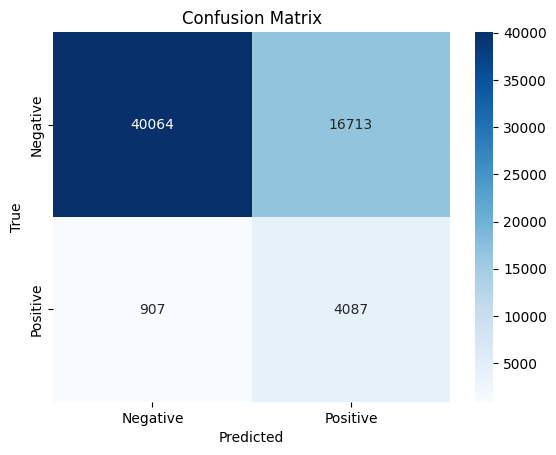

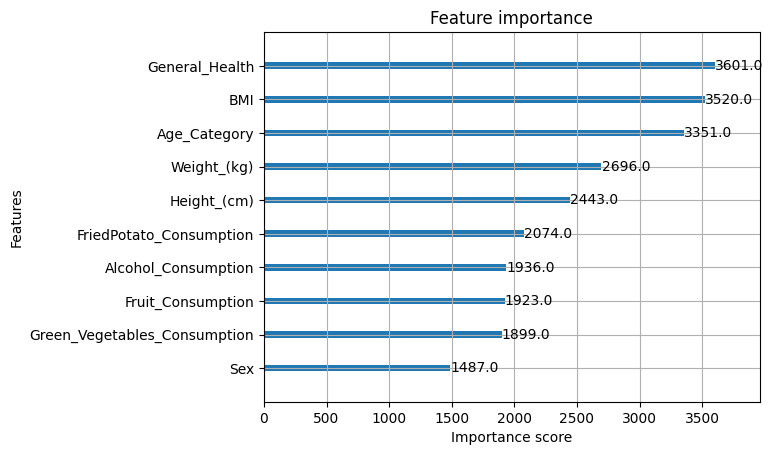


Classification Report:
              precision    recall  f1-score   support

      No CVD     0.9779    0.7056    0.8197     56777
         CVD     0.1965    0.8184    0.3169      4994

    accuracy                         0.7148     61771
   macro avg     0.5872    0.7620    0.5683     61771
weighted avg     0.9147    0.7148    0.7791     61771



In [ ]:

# Remove 'ID' column from the dataset
X_train = X_train.drop(columns=['ID'], axis=1)
X_test = X_test.drop(columns=['ID'], axis=1)

# Preprocessing: Label encode categorical features
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Label encoding for categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(pd.concat([X_train[col], X_test[col]]))  # Fit on both train and test data
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Hyperparameter tuning for XGBoost using RandomizedSearchCV
param_dist = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 700, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [6, 8, 10],
}

# Use RandomizedSearchCV for hyperparameter search
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='mlogloss'),
    param_distributions=param_dist,
    n_iter=50,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

#  Fit the model with the best parameters
random_search.fit(X_train, y_train)

# Output the best parameters and cross-validation score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best cross-validation AUC score: {random_search.best_score_:.4f}")

#  Train the final model with the best parameters and make predictions
best_model = random_search.best_estimator_

# Predict probabilities (needed for threshold adjustment)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Adjust the classification threshold for better precision
threshold = 0.45
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)  # Focus on recall for CVD (positive class)
precision = precision_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.show()

# Print classification report (including macro and weighted averages)
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['No CVD', 'CVD'], digits=4))









### Random Forest (Tom)

In [ ]:
# Copy train and test data
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

# Ordinal encoding for General_Health
health_categories = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
ord_enc_health = OrdinalEncoder(categories=[health_categories])

X_train_enc['General_Health'] = ord_enc_health.fit_transform(X_train_enc[['General_Health']])
X_test_enc['General_Health'] = ord_enc_health.transform(X_test_enc[['General_Health']])

# Ordinal encoding for Age_Category
age_categories = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
ord_enc_age = OrdinalEncoder(categories=[age_categories])

X_train_enc['Age_Category'] = ord_enc_age.fit_transform(X_train_enc[['Age_Category']])
X_test_enc['Age_Category'] = ord_enc_age.transform(X_test_enc[['Age_Category']])

# Binary encoding for Sex
sex_mapping = {'Male': 0, 'Female': 1}
X_train_enc['Sex'] = X_train_enc['Sex'].map(sex_mapping)
X_test_enc['Sex'] = X_test_enc['Sex'].map(sex_mapping)

# Drop ID
X_train_enc = X_train_enc.drop('ID', axis=1)
X_test_enc = X_test_enc.drop('ID', axis=1)

In [ ]:
# Define Random Forest and hyperparameter grid
rf = RandomForestClassifier(random_state=1, n_jobs=-1)

param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=1)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=n_iterations,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=1
)

# Fit model
random_search.fit(X_train_enc, y_train)

# Best parameters
print("Best hyperparameters:", random_search.best_params_)

# Best estimator
best_rf = random_search.best_estimator_

# Evaluate model
y_pred = best_rf.predict(X_test_enc)
y_pred_prob = best_rf.predict_proba(X_test_enc)[:, 1]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print("AUROC:", auroc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report (precision, recall, F1)
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_enc.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.title('Feature Importance')
plt.show()

### Logistic Regression (Bernadette)

In [ ]:
if 'ID' in X_train.columns:
    X_train = X_train.drop('ID', axis=1)
    X_test = X_test.drop('ID', axis=1)

# Handle Age_Category type
if 'Age_Category' in X_train.columns:
    X_train['Age_Category'] = X_train['Age_Category'].astype('category')
    X_test['Age_Category'] = X_test['Age_Category'].astype('category')
    print("✅ Age_Category forced to category type.")
else:
    print("⚠️")

# Identify feature types
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'Age_Category' in categorical_features:
    print(f"✅ Age_Category included in categorical features: {categorical_features}")
else:
    print("⚠️")

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out=False
)

# Model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='log_loss',
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])


# Hyperparameter space
param_dist = {
    'classifier__alpha': np.logspace(-5, 1, 7),
    'classifier__learning_rate': ['optimal', 'invscaling'],
    'classifier__eta0': [0.001, 0.01, 0.1],
    'classifier__max_iter': [1000, 1500],
    'classifier__tol': [1e-4, 1e-3, 1e-2],
}

# Hyperparameter search (100 trials + 5-fold cross-validation)
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=n_iterations,  # 100次超参数调优
    cv=cv_folds,        # 5折交叉验证
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# fitting
try:
    print("Starting hyperparameter tuning (100 trials + 5-fold cross-validation)...")
    random_search.fit(X_train, y_train)
except KeyboardInterrupt:
    best_model = random_search.best_estimator_ if hasattr(random_search, 'best_estimator_') else model_pipeline
else:
    best_model = random_search.best_estimator_

# Prediction
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# metrics calculation
auroc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
TP = conf_matrix[1, 1] if conf_matrix.shape[0] > 1 else 0
TN = conf_matrix[0, 0] if conf_matrix.shape[0] > 0 else 0
FP = conf_matrix[0, 1] if conf_matrix.shape[1] > 1 else 0
FN = conf_matrix[1, 0] if conf_matrix.shape[0] > 1 else 0

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # 召回率
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # 假阳性率

# Get classification report as dictionary for combined metrics
report = classification_report(y_test, y_pred, output_dict=True)
combined_metrics = {
    'macro_precision': report['macro avg']['precision'],
    'macro_recall': report['macro avg']['recall'],
    'macro_f1': report['macro avg']['f1-score'],
    'weighted_precision': report['weighted avg']['precision'],
    'weighted_recall': report['weighted avg']['recall'],
    'weighted_f1': report['weighted avg']['f1-score']
}

# Feature importance calculation
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

classifier = best_model.named_steps['classifier']
coef = classifier.coef_[0]

# Build feature importance DataFrame and sort
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Importance': np.abs(coef)
}).sort_values(by='Importance', ascending=False) # Sort by importance descending

# Merge age group features
age_features = feature_importance[feature_importance['Feature'].str.startswith('Age_Category_')]
total_age_importance = age_features['Importance'].sum()
merged_age = pd.DataFrame([{
    'Feature': 'Age (Combined)',
    'Coefficient': 'N/A (Grouped)',
    'Importance': total_age_importance
}])
non_age_features = feature_importance[~feature_importance['Feature'].str.startswith('Age_Category_')]
feature_importance_merged = pd.concat([non_age_features, merged_age], ignore_index=True)

feature_importance_merged = feature_importance_merged.sort_values(by='Importance', ascending=False)


✅ Age_Category forced to category type.
✅ Age_Category included in categorical features: ['General_Health', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']


In [ ]:





##
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Output results with combined metrics
print("\n===== Logistic Regression Results =====")
print(f"AUROC: {auroc:.4f} | Accuracy: {accuracy:.4f}")
print(f"TPR: {TPR:.4f} | FPR: {FPR:.4f}")

# Print combined precision/recall/f1
print("\n===== Combined Metrics (Macro & Weighted Averages) =====")
print(f"Macro Precision: {combined_metrics['macro_precision']:.4f} | Macro Recall: {combined_metrics['macro_recall']:.4f} | Macro F1: {combined_metrics['macro_f1']:.4f}")
print(f"Weighted Precision: {combined_metrics['weighted_precision']:.4f} | Weighted Recall: {combined_metrics['weighted_recall']:.4f} | Weighted F1: {combined_metrics['weighted_f1']:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report (Per Class):")
print(classification_report(y_test, y_pred))

print("\n===== All Features Importance (Sorted) =====")
print(feature_importance)

##
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')


Starting hyperparameter tuning (100 trials + 5-fold cross-validation)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

===== Logistic Regression Results =====
AUROC: 0.8310 | Accuracy: 0.7390
TPR: 0.7805 | FPR: 0.2646

===== Combined Metrics (Macro & Weighted Averages) =====
Macro Precision: 0.5902 | Macro Recall: 0.7580 | Macro F1: 0.5821
Weighted Precision: 0.9123 | Weighted Recall: 0.7390 | Weighted F1: 0.7968

Confusion Matrix:
[[41752 15025]
 [ 1096  3898]]

Classification Report (Per Class):
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     56777
           1       0.21      0.78      0.33      4994

    accuracy                           0.74     61771
   macro avg       0.59      0.76      0.58     61771
weighted avg       0.91      0.74      0.80     61771


===== All Features Importance (Sorted) =====
                         Feature  Coefficient  Importance
38              Age_Category_80+     1.644512   

### LightGBM (Emma)

In [ ]:
def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False,
    }

    # create model with above parameters
    model = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

In [ ]:
X_train = X_train.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

# set the optimal hyperparameters found above
best_params = {
    'n_estimators': 199,
    'max_bin': 861,
    'learning_rate': 0.04655946801164591,
    'max_depth': 5,
    'num_leaves': 68,
    'bagging_fraction': 0.7822571881127822,
    'feature_fraction': 0.5351453860763787,
    'lambda_l2': 0.004895224282750673,
    'min_sum_hessian_in_leaf': 0.00016000103886610034,
    'min_data_in_leaf': 986,
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False,
}

# train the final model
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# make predictions with test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = final_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()